In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2023-01-24 15:27


# Functional conservation among top morphologs?

The reviewers noted that in the MorF pipeline we used the top hit to transfer functional annotation for each _Spongilla_ protein. They wondered if there was agreement in the functional annotation within between the morphologs ("no meaningful difference in score") of each protein, and how often it happened that the first and second best morphologs would have a small difference in score but different functions. These questions are straightforward but are non-trivial to answer.

First, we need to define "top hits" in a meaningful way. It can't just be the top N scoring morphologs, since the differences in bit score may differ wildly between queries, or drop off very quickly between one rank and the next. Similarly, we can't use a global cut-off, as the morphologs of different query proteins are in completely different bit score ranges, also depending on the respective alignment length. The thresholding has to happen in a query-specific way, but with a strategy that is general enough to be applied to all queries.

Second, answering the question requires us to get functional annotations for a (very) large number of proteins. To keep things comparable to the manuscript this would have to happen via EggNOG orthogroups and their related annotation. Unfortunately, to the best of our knowledge, there is no programmatic way to get that information from the EggNOG database. The best workaround we found so far is to identify the proteins we want functional information for, retrieve their sequences from UniProt, submit these sequences to emapper, retrieve the results, and keep the best hit per sequence, which is going to be the identity match of the sequence to itself. This is a lamentably circuitous way of getting information that, in some way, is definitely included in the EggNOG databases; unfortunately, we cannot think of a better way of accessing it.

We will again use the EC number as an easily accessible and easily comparable descriptor of function, knowing that it will restrict our comparisons to a limited subset of query proteins and their morphologs.

In [2]:
import glob
from os.path import exists
from tqdm import tqdm
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from skimage import filters

Read the predictions and cutoffs:

In [3]:
filtered = pd.read_csv("../data/revision/filtered_afdb.tsv", sep="\t", index_col=0)

cutoffs = pd.read_csv("../data/revision/cutoffs.tsv", sep="\t", index_col=0)

Read the annotations, keep the best hit per query, and concatenate into one big table. Not all of UniProt is in Emapper, so drop cases with less than stellar e-values:

In [4]:
res = []
for f in glob.glob("../data/eggnog_fastas/*.tsv"):
    annot_fragment = pd.read_csv(f, sep="\t", skiprows=4, skipfooter=3, engine="python")
    annot_fragment["id"] = annot_fragment["#query"].str.split("|").str[1]
    beyond_reasonable_doubt = annot_fragment[annot_fragment["evalue"] < 1e-100]

    unique_ids = beyond_reasonable_doubt["id"].unique().shape 
    all_ids = beyond_reasonable_doubt["id"].shape
    if unique_ids != all_ids:
        beyond_reasonable_doubt = beyond_reasonable_doubt.sort_values("evalue").drop_duplicates("id")
    beyond_reasonable_doubt.set_index("id", inplace=True)

    res.append(beyond_reasonable_doubt.copy())
    
annot = pd.concat(res)

Merge with our prediction matrix:

In [5]:
filtered = filtered.join(annot, on="uniprot")

Slim down the matrix by dropping unnecessary columns and singleton rows:

In [6]:
informative_columns = ["query", "bit score", "uniprot", "eggNOG_OGs", "Preferred_name", "EC"]

In [7]:
# slim = filtered[informative_columns]
filtered["EC"].replace("-", None, inplace=True)
has_EC = ~filtered["EC"].isnull()
slim = filtered[has_EC][informative_columns]
is_not_singleton = slim["query"].duplicated(keep=False)
slim = slim[is_not_singleton]

In [8]:
filtered.shape, slim.shape

((2115799, 35), (334889, 6))

Define functions to compare EC numbers and score entire columns:

In [9]:
def string_cumsum(x):
    lis = x.split(".")
    res = [lis[0]]
    total = lis[0]
    for x in lis[1:]:
        total = total + "." + x
        res.append(total)
    return np.array(res)

In [10]:
def compare_EC(x, target):
    query = [string_cumsum(ec) for ec in x.split(",")]
    target = [string_cumsum(ec) for ec in target.split(",")]
    max_agreement = 0
    for q in query:
        for t in target:
            tmp = np.sum(q == t)
            if tmp > max_agreement:
                max_agreement = tmp
    return max_agreement

In [11]:
def calc_EC_overlap(df):
    df = df.sort_values("bit score", ascending=False)
    best_hit = df.iloc[0]["EC"]
    return df["EC"].apply(compare_EC, target=best_hit)

In [12]:
def otsu_score(df):
    # print(df["query"].iloc[0])
    agreement = calc_EC_overlap(df)
    # print(agreement, (np.sum(agreement) - 4), ((df.shape[0] - 1) * 4))
    otsu_agreement = (np.sum(agreement) - 4) / ((df.shape[0] - 1))
    return otsu_agreement

In [13]:
def top10p_score(df, cutoffs):
    agreement = calc_EC_overlap(df)
    query = df.iloc[0]["query"]
    top10percent = df["bit score"] > cutoffs["top10%"].loc[query]
    niko_agreement = (np.sum(agreement[top10percent]) - 4) / ((np.sum(top10percent) - 1))
    return niko_agreement

Calculate the average EC overlap for the two thresholds:

In [14]:
otsu = slim.groupby("query").apply(otsu_score)
top10p = slim.groupby("query").apply(top10p_score, cutoffs=cutoffs)

Calculate how many morphologs pass the threshold for each query:

In [15]:
def how_many_top10p(df, cutoffs):
    query = df.iloc[0]["query"]
    top10percent = df["bit score"] > cutoffs["top10%"].loc[query]
    return np.sum(top10percent)

In [16]:
top10p_howmany = slim.groupby("query").apply(how_many_top10p, cutoffs=cutoffs)
otsu_howmany = slim.groupby("query").apply(len)

No need to exclude anything on the Otsu side, as each query has at least two morphologs (= we can ask how much top morphologs agree on the functional side)

In [17]:
np.sum(otsu_howmany < 2)

0

On the other hand, the 90th percentile threshold is quite strict, so we'll end up with lots more singletons, which we should remove:

In [18]:
exclude = top10p_howmany < 2

How do the two thresholds compare? Let's start with a good old scatter plot:

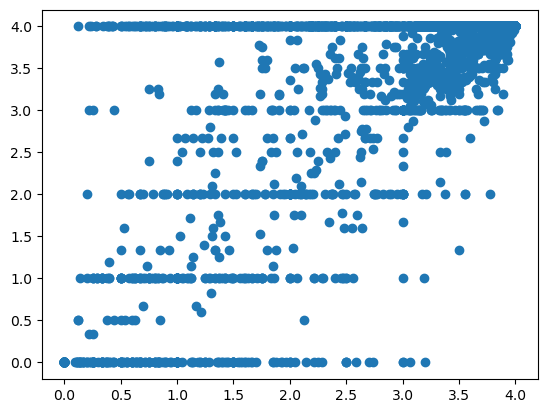

In [19]:
fig, ax = plt.subplots()
ax.scatter(otsu[~exclude], top10p[~exclude])

Broad agreement but too many overlapping points to see anything useful. Gratifying to notice that there are clearly more points above the diagonal, on the side of the stricter threshold. Let's try a sorted plot:

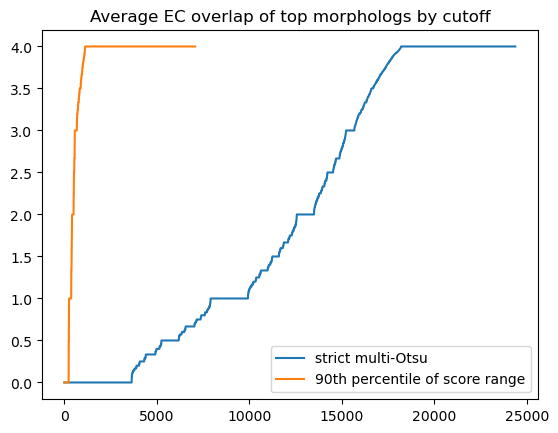

In [20]:
fig, ax = plt.subplots()
ax.plot(np.sort(otsu), label="strict multi-Otsu")
ax.plot(np.sort(top10p[~exclude]), label="90th percentile of score range")
ax.set_title("Average EC overlap of top morphologs by cutoff")
ax.legend();

It looks like the 90th percentile cutoff is way steeper, but this may be due to a smaller x axis. Let's have a look at the distribution of average EC overlap:

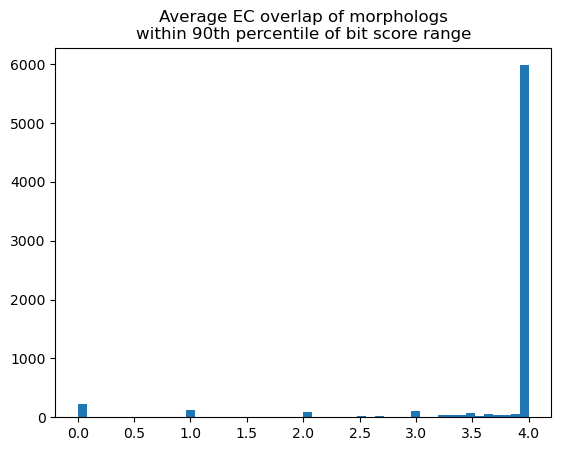

In [21]:
fig, ax = plt.subplots()
# ax.hist(otsu[~exclude], bins=50, label="strict multi-Otsu")
bla = top10p[~exclude].copy()
bla[bla.isna()] = -1
ax.hist(bla, bins=50, label="top 10% score range")
# ax.legend()
ax.set_title("Average EC overlap of morphologs\nwithin 90th percentile of bit score range");

Very impressive - almost exclusively complete agreement, and a bunch of cases between 3-4, which means only a few of the top morphologs disagree.

How many enzymes are we comparing anyway?

In [22]:
len(top10p) - np.sum(exclude)

7072

Same plot for Otsu threshold:

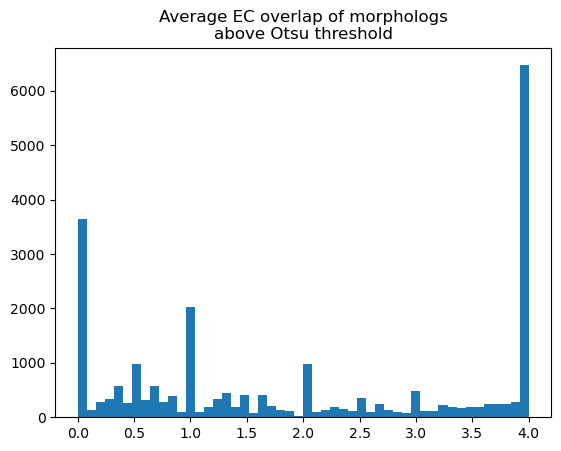

In [23]:
fig, ax = plt.subplots()
# ax.hist(otsu[~exclude], bins=50, label="strict multi-Otsu")
bla = otsu.copy()
bla[bla.isna()] = -1
ax.hist(bla, bins=50, label="top 10% score range")
# ax.legend()
ax.set_title("Average EC overlap of morphologs\nabove Otsu threshold");

A lot more cases with (way) less overlap. The Otsu thresholds are clearly too permissive.

How many morphologs does each thresholding strategy allow?

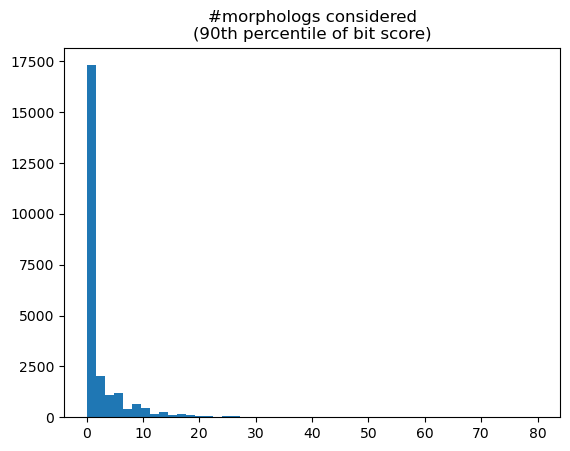

In [24]:
fig, ax = plt.subplots()
ax.set_title("#morphologs considered\n(90th percentile of bit score)")
ax.hist(top10p_howmany, bins=50);

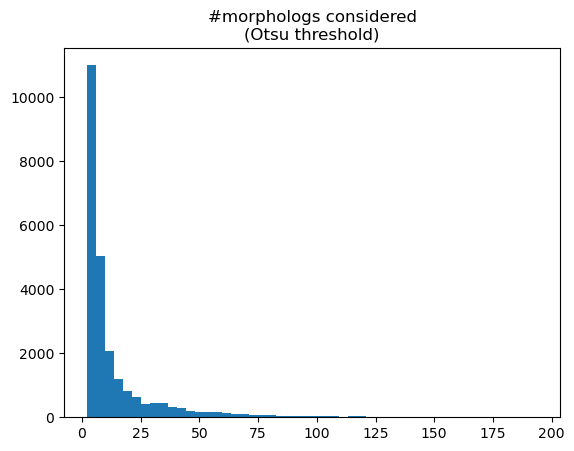

In [25]:
fig, ax = plt.subplots()
ax.set_title("#morphologs considered\n(Otsu threshold)")
ax.hist(otsu_howmany, bins=50);

Same shape but different x axes; this was expected. Let's calculate some averages for the answer:

In [26]:
np.mean(top10p_howmany[~exclude])

7.3710407239819

In [27]:
np.mean(otsu_howmany)

13.736218211648893

In [28]:
np.mean(top10p[~exclude])

3.715391961044127

Let's also try and answer the question of agreement/disagreement between the first and second best morpholog! We will restrict this to the 90th percentile, which clearly does a better job at identifying cases with significant structural similarity:

In [29]:
def first_and_second(df, cutoffs):
    agreement = calc_EC_overlap(df)
    query = df.iloc[0]["query"]
    top10percent = df["bit score"] > cutoffs["top10%"].loc[query]
    try:
        return agreement[top10percent].iloc[1]
    except IndexError:
        return -1

In [30]:
top10p_12 = slim.groupby("query").apply(first_and_second, cutoffs=cutoffs)

In [31]:
np.unique(top10p_12[~exclude], return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 299,  133,   74,  188, 6378]))

In [32]:
np.sum(top10p_12[~exclude] < 4) / np.sum(top10p_12[~exclude] > 3)

0.1088115396676074

In [33]:
np.sum(top10p_12[~exclude] < 3) / np.sum(top10p_12[~exclude] > 3)

0.07933521480087802

In [36]:
np.mean(top10p_12[~exclude][top10p_12[~exclude] < 4])

1.217579250720461

In [41]:
top10p_12[~exclude][top10p_12[~exclude] < 4]

query
132      0
142      3
170      0
215      0
252      1
        ..
41535    1
41596    0
41621    1
41703    3
41934    1
Length: 694, dtype: int64

In [54]:
slim[slim["query"] == 41596]

query  bit score     uniprot  \
1798577  41596        367      Q22707   
1798580  41596        356      C0PFH1   
1798581  41596        347      B7EQL6   
1798582  41596        347  A0A1D6EGX8   
1798583  41596        344  A0A0H5S9H8   
1798584  41596        343      Q6NXK5   
1798585  41596        337      Q2QWJ7   
1798588  41596        330      O75319   
1798589  41596        328      Q4KM79   
1798590  41596        323  A0A3P7GI08   
1798592  41596        319      I1N9F9   
1798595  41596        296      E9QD92   
1798596  41596        288      Q8GSD7   
1798597  41596        286  A0A0R0KQX0   
1798598  41596        276      F4IYM6   
1798599  41596        273      Q8SX38   
1798600  41596        272      P34442   
1798601  41596        270      J9BD64   
1798602  41596        265      K7MTE7   
1798603  41596        259  A0A0N4U7Y1   
1798604  41596        259      K7KDH1   
1798606  41596        254      Q6NY98   
1798607  41596        254      I1KKA0   
1798608  41596        250      K7K355   
1798609  41596        246      O60942   
1798610  41596        238      O55236   
1798611  41596        238      Q9VY44   
1798612  41596        233  A0A5K4FAB6   
1798614  41596        226      Q17607   
1798615  41596        219      D3ZH30   
1798616  41596        211  A0A0N4UCR5   
1798618  41596        198  A0A183XJR9   

                                                eggNOG_OGs Preferred_name  \
1798577  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798580  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798581  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798582  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798583  COG5226@1|root,KOG2386@2759|Eukaryota,3A2XY@33...              -   
1798584  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798585  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798588  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798589  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798590  COG5226@1|root,KOG2386@2759|Eukaryota,3A2XY@33...              -   
1798592  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798595  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798596  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798597  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798598  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798599  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798600  COG5226@1|root,KOG2386@2759|Eukaryota,3A2XY@33...              -   
1798601  COG5226@1|root,KOG2386@2759|Eukaryota,38WCH@33...         DUSP11   
1798602  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798603  COG5226@1|root,KOG2386@2759|Eukaryota,3A2XY@33...              -   
1798604  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798606  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798607  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798608  COG5226@1|root,KOG2386@2759|Eukaryota,37QNS@33...              -   
1798609  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798610  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798611  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798612  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798614  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798615  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798616  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   
1798618  COG5226@1|root,KOG2386@2759|Eukaryota,38DZV@33...          RNGTT   

                                EC  
1798577          3.1.3.16,3.1.3.48  
1798580                   2.7.7.50  
17

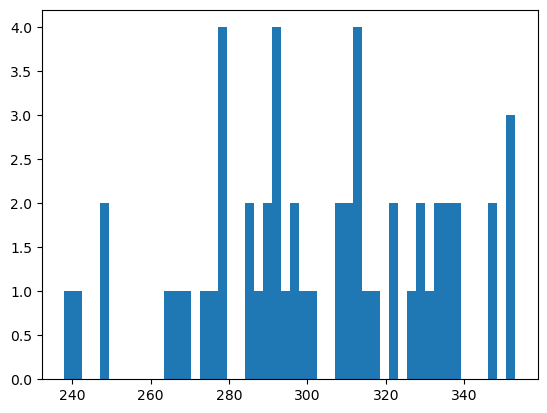

In [49]:
fig, ax = plt.subplots()
ax.hist(slim[slim["query"] == 142]["bit score"], bins=50);

In [37]:
np.mean(otsu)

2.0235220058305226

## Summary

For enzymes, there are on average 7.37 top morphologs for each query within a certain score margin (90th percentile of bit score range); their function has almost no variation at all, with an average EC overlap with the top hit of 3.7/4.

For the same group of proteins, the first and second best morphologs differ in EC number approx. 11% of the time.